In [74]:

import rasterio
import rasterio.features
import rasterio.warp

from matplotlib import pyplot
import geopandas
from geopandas import GeoDataFrame, GeoSeries
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns
from shapely.geometry import Point, Polygon
import numpy as np
from datetime import datetime
import json
plt.rcParams["figure.figsize"] = [8,6]

In [103]:
# load tiff file and create ndarray
file_name = "Hansen_GFC-2020-v1.8_lossyear_40N_130W.tif"
img = rasterio.open(file_name)
tiff_array = img.read(1)

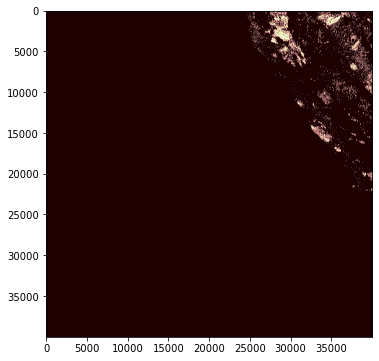

In [73]:
pyplot.imshow(tiff_array, cmap='pink')

In [75]:
# Get coordinates of the corners
with rasterio.open("Hansen_GFC-2020-v1.8_lossyear_40N_130W.tif") as dataset:


    temp = tools.JSONSequenceTool(dataset)
    print(temp)
    
    # Read the dataset's valid data mask as a ndarray.
    mask = dataset.dataset_mask()

    # Extract feature shapes and values from the array.
    for geom, val in rasterio.features.shapes(mask, transform=dataset.transform):
        print(val)

        # Transform shapes from the dataset's own coordinate
        # reference system to CRS84 (EPSG:4326).
        geom = rasterio.warp.transform_geom(
            dataset.crs, 'EPSG:4326', geom, precision=6)

        # Print GeoJSON shapes to stdout.
        print(geom)

255.0
{'type': 'Polygon', 'coordinates': [[[-130.0, 40.0], [-130.0, 30.0], [-120.0, 30.0], [-120.0, 40.0], [-130.0, 40.0]]]}


In [86]:
coords = geom['coordinates']
top_right = coords[0][1]
bottom_left = coords[0][3]
print(coords)
print(top_right)
print(bottom_left)

[[[-130.0, 40.0], [-130.0, 30.0], [-120.0, 30.0], [-120.0, 40.0], [-130.0, 40.0]]]
[-130.0, 30.0]
[-120.0, 40.0]


In [90]:
%matplotlib agg
%matplotlib agg


# Bottom left corner
boundy1, boundx1 = bottom_left[1], bottom_left[0]  #32.5239920572277, -124.38498819727948
# Top right corner (near top right of nevada to capture all of CA)
boundy2, boundx2 = top_right[1], top_right[0] #42.01477274871176, -114.13276715586254


plt.gca().set_xlim([boundx1, boundx2])
plt.gca().set_ylim([boundy1, boundy2])

# make a grid of latitude-longitude values
xmin, xmax, ymin, ymax = boundx1, boundx2, boundy1, boundy2

# Calculation to ensure length and width are uniform (squares appx., not rectangles)
# 400 squares width for the length of california (based on the above boundaries)
# Note here that xx, yy are for ALL OF california. Use xc, yc for the specific region.
granularity = 400
xx, yy = np.meshgrid(np.linspace(xmin,xmax,granularity), np.linspace(ymin,ymax, int(granularity/abs(xmax - xmin) * abs(ymax - ymin))))
print(xx.shape) # Again, xx, yy are rectangular grids on the entirety of CA (+ Nevada, ocean)

(400, 400)


In [107]:
# Place the list of all relevant coordinates into a json file. For now, each of them point to blank {}
# In the future, they point to the features:data (e.g. {feature1: datum1, feature2:datum2, ...} as value per pair of coords)
region_coords = {}
for i in range(len(xx)):
    region_coords[str(xx[i]) + ',' + str(yy[i])] = {}
    
json_file_name = file_name[:-4] + '.json'

with open(json_file_name, 'w') as f:
    json.dump(region_coords, f)